<a href="https://colab.research.google.com/github/Steve-YJ/Assignment_Standalone_DL/blob/master/Lab7_Basic_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [62]:
! mkdir results

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args

# Data Preparation

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
partition = {'train': trainset, 'val':valset, 'test':testset}

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Model Architecture
* 📌 <code>MLP -> CNN</code>
    * MLP에서 CNN으로 모델을 교체해준다

In [40]:
class CNN1(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # 기본적인 CNN 구조를 만들어보자!
        self.conv1 = nn.Conv2d(in_channels = 3,
                               out_channels = 64,
                               kernel_size = 3,
                               stride = 1,
                               padding=1)
        self.act = nn.ReLU()
        # Add MaxPool2D
        self.maxpool1 = nn.MaxPool2d(kernel_size=2,
                                     stride=2)
        self.conv2 = nn.Conv2d(in_channels=64,
                               out_channels=256,
                               kernel_size=5,
                               stride=1,
                               padding=2)
        # Add FC Layer
        self.fc = nn.Linear(65536, 10)  # 10-way Classification
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.act(x)
        x = self.conv2(x)
        x = self.act(x)
        x = self.maxpool1(x)  # [N, 256, 32, 32] -> [N, 256, 16, 16]
        x = x.view(x.size(0), -1)   # batch_size Dimension은 유지시켜준다
                                    # x.size(0): N(batch_num)
        x = self.fc(x)
        return x   

### Make VGG Architecture

In [ ]:
"""
Reference: https://github.com/kuangliu/pytorch-cifar/blob/master/models/vgg.py
"""

In [31]:

cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

In [60]:
class CNN(nn.Module):
    
    def __init__(self, model_code, in_channels, out_dim, act, use_bn):
        super(CNN, self).__init__()
        if act == 'relu':
            self.act = nn.ReLU()
        elif act == 'sigmoid':
            self.act = nn.Sigmoid()
        elif act == 'tanh':
            self.cat = nn.Tanh()
        else:
            raise ValueError("Not a valid activation function code")

        self.layers = self._make_layers(model_code, in_channels, use_bn)  # private function
        self.linear = nn.Linear(512, 10)
        self.classifier = nn.Sequential(nn.Linear(512, 256),
                                        self.act,
                                        nn.Linear(256, out_dim))  # 마지막 레이어에서는 Activation Function을 거치지 않는다

    def forward(self, x):
        x = self.layers(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _make_layers(self, model_code, in_channels, use_bn):
        layers = []  # ModuleLIst를 만들어야하지 않아요?
                     # A. list로 만들어 Sequential함수 사용
        for x in cfg[model_code]:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels=in_channels, 
                                     out_channels = x,
                                     kernel_size=3,
                                     stride=1,
                                     padding=1)]
                if use_bn:
                    layers += [nn.BatchNorm2d(x)]         
                layers += [self.act]  # 여기서 끝냈을 때 문제점이 있을까?
                in_channels = x
        return nn.Sequential(*layers)

In [51]:
def dim_check():
    net = CNN('VGG11', 3)
    x = torch.randn(2, 3, 32, 32)
    return net(x).shape

dim_check()

torch.Size([2, 10])

마지막 layer가 1x1이 되도 되는거야?<br>
마지막 layer는 전체 이미지를 보고 있다

📌 <code>차원수를 확인해주는 것</code>이 필요하다!

In [19]:
def dim_check():  # dimension check function
    net = CNN()
    x = torch.randn(20, 3, 32, 32)
    return net(x).shape  # Expect (20, 10)

dim_check()

torch.Size([20, 10])

# Train, Validation, Test

In [29]:
def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'], 
                                              batch_size=args.train_batch_size, 
                                              shuffle=True, num_workers=2)
    net.train()  # train mode
    optimizer.zero_grad()  # optimizer 초기화

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        # print('input dimension: ', inputs.shape)
        # raise RuntimeError
        # inputs = inputs.view(-1, 3072)
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc


In [21]:
def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'], 
                                            batch_size=args.test_batch_size, 
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0 
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            # images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

In [22]:
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'], 
                                             batch_size=args.test_batch_size, 
                                             shuffle=False, num_workers=2)
    net.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            # images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

In [56]:
def experiment(partition, args):

    net = CNN(model_code = args.model_code,
              in_channels = args.in_channels,
              out_dim = args.out_dim,
              act = args.act,
              use_bn = args.use_bn)
    net.cuda()

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    # ===== List for epoch-wise data ====== #
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    # ================= Training ==================== #
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()
        
        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # ============================ #
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
    test_acc = test(net, partition, args)    
    
    # ======= Add Result to Dictionary ======= #
    # 전체 결과값을 저장하는 Results Dic 
    # Q. 왜 때문인진 모르겠지만 train_accs와 train_acc가 분리되어있네?!
        # train_acc와 val_acc은 없어도 되는거 아냐?
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    # result['train_acc'] = train_acc
    # result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result  # vars(args)를 해주면 args를 dic로 저장해준다
    # ===================================== #

# Manage Experiment

In [24]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):  # setting: args
                                       # result : train_losses, val_losses, train_accs, val_accs,  
    exp_name = setting['exp_name']
    del setting['epoch']               # setting에서 'epoch'과 'test_batch_size'를 제거해준다고...
    del setting['test_batch_size']     # 왜 떼는거지?

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]  # setting에 따라 다른 파일명을 갖도록 만들어준다
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)  # 결과 dictionary에 setting값을 더해준다 => Dic
    with open(filename, 'w') as f:
        json.dump(result, f)  # JSON 포멧으로 dictionary 값 저장

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]  # ./resuts에 저장되어있는 file들을 리스트 형태로 저장
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            # print(exp_name)
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)  # Dic을 list형태로 저장
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

# Experiment

In [63]:
# ====== Random Seed Initialization ====== #
seed = 123  # 랜덤 시드값 초기화
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_lr_model_code"

# ====== Model ====== #
args.model_code ='VGG11'
args.in_channels = 3
args.out_dim = 10
# args.hid_dim = 100
args.act = 'relu'

# ====== Regularization ======= #
args.l2 = 0.00001
args.use_bn = True

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0015
args.epoch = 10

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'lr'
name_var2 = 'model_code'
list_var1 = [0.0001, 0.00001]
list_var2 = ['VGG11', 'VGG13']


for var1 in list_var1:
    for var2 in list_var2:
        # setattr ??: name_var1('n_layer')를 1, 2, 3으로 바꿔준다
        # setattr = args.name_var1 = var1
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(act='relu', epoch=10, exp_name='exp1_lr_model_code', in_channels=3, l2=1e-05, lr=0.0001, model_code='VGG11', optim='RMSprop', out_dim=10, test_batch_size=1024, train_batch_size=256, use_bn=True)
Epoch 0, Acc(train/val): 36.81/40.79, Loss(train/val) 1.61/1.59. Took 6.35 sec
Epoch 1, Acc(train/val): 50.55/56.51, Loss(train/val) 1.32/1.20. Took 6.39 sec
Epoch 2, Acc(train/val): 59.73/57.26, Loss(train/val) 1.10/1.17. Took 6.27 sec
Epoch 3, Acc(train/val): 65.94/65.78, Loss(train/val) 0.94/0.95. Took 6.39 sec
Epoch 4, Acc(train/val): 70.00/66.35, Loss(train/val) 0.83/0.94. Took 6.49 sec
Epoch 5, Acc(train/val): 73.29/69.64, Loss(train/val) 0.74/0.89. Took 6.43 sec
Epoch 6, Acc(train/val): 76.93/71.79, Loss(train/val) 0.65/0.81. Took 6.52 sec
Epoch 7, Acc(train/val): 79.85/70.10, Loss(train/val) 0.58/0.89. Took 6.58 sec
Epoch 8, Acc(train/val): 82.00/73.20, Loss(train/val) 0.52/0.83. Took 6.52 sec
Epoch 9, Acc(train/val): 84.08/76.40, Loss(train/val) 0.47/0.72. Took 6.45 sec
Names

## 결과 Report 및 시각화

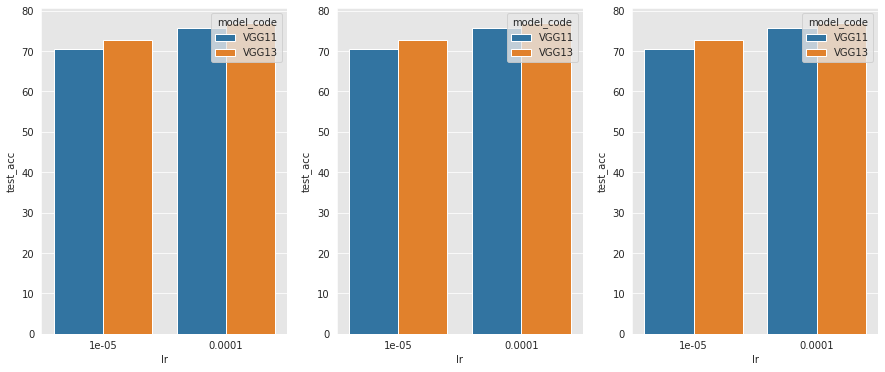

In [66]:
import seaborn as sns 
import matplotlib.pyplot as plt

df = load_exp_result('exp1')

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 6)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

sns.barplot(x='lr', y='test_acc', hue='model_code', data=df, ax=ax[0])
sns.barplot(x='lr', y='test_acc', hue='model_code', data=df, ax=ax[1])
sns.barplot(x='lr', y='test_acc', hue='model_code', data=df, ax=ax[2])

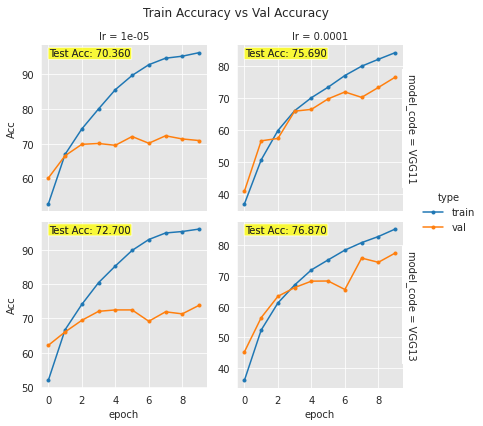

In [67]:
var1 = 'lr'
var2 = 'model_code'

df = load_exp_result('exp1')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_accs = list(row.train_accs)[0]
        val_accs = list(row.val_accs)[0]
        test_acc = list(row.test_acc)[0]
        
        for epoch, train_acc in enumerate(train_accs):
            list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_acc in enumerate(val_accs):
            list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

def show_acc(x, y, metric, **kwargs):
    plt.scatter(x, y, alpha=0.3, s=1)
    metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
    plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

g.add_legend()
g.fig.suptitle('Train Accuracy vs Val Accuracy')



plt.subplots_adjust(top=0.89)